<a href="https://colab.research.google.com/github/suhyeon03/DeepLearning/blob/main/ch8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝

In [1]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch.git
import sys
sys.path.append('/content/deep-learning-from-scratch')

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 1118, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 1118 (delta 141), reused 130 (delta 130), pack-reused 943 (from 2)
Receiving objects: 100% (1118/1118), 52.68 MiB | 32.83 MiB/s, done.
Resolving deltas: 100% (644/644), done.


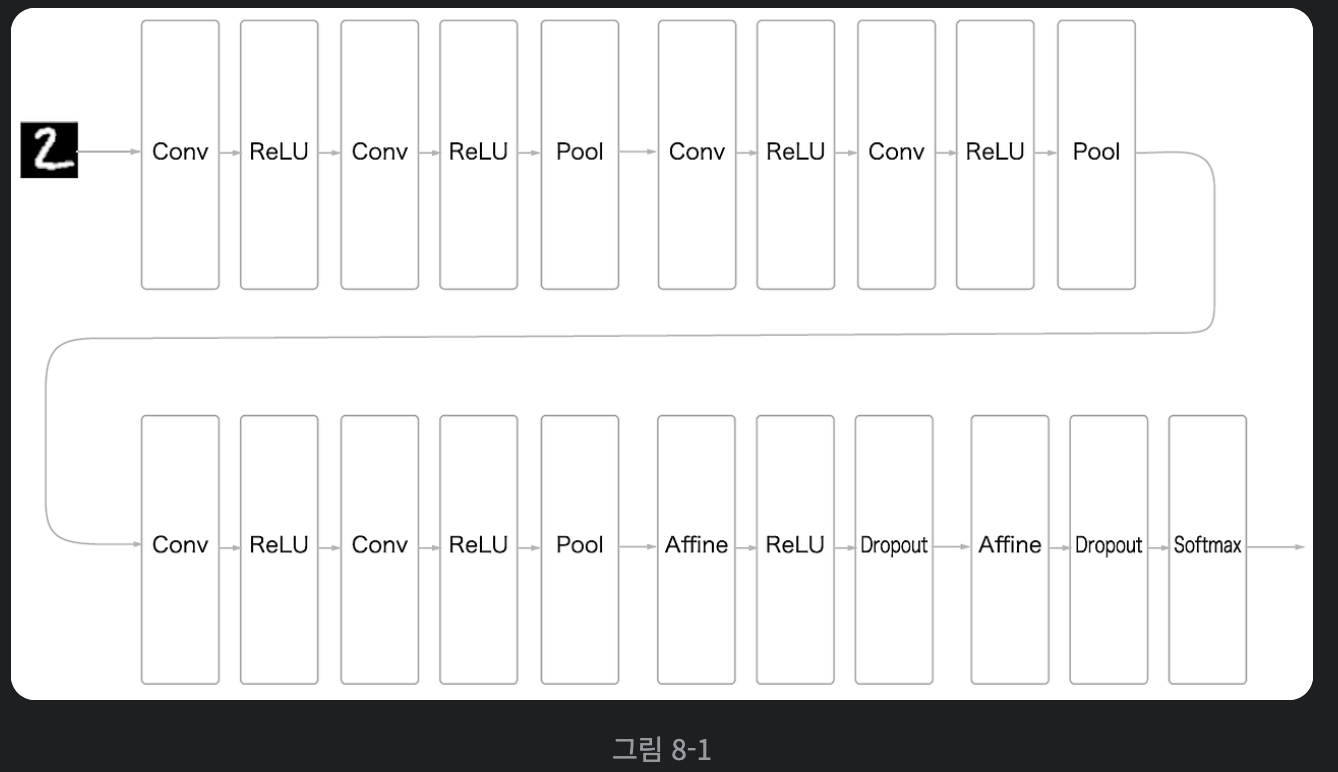

* 그림 8-1과 같이 구성된 CNN을 만들고자 한다.

* 여기에서 사용하는 합성곱 계층은 모두 3x3 크기의 작은 필터로 층이 깊어지면서 채널 수가 더 늘어나는 것이 특징이다. 합성곱 계층의 채널 수는 앞 계층에서부터 순서대로 16, 16, 32, 32, 64, 64로 늘어간다.

* 그림과 같이 풀링 계층을 추가하여 중간 데이터의 공간 크기를 점차 줄여가고 마지막 단의 완전 연결 계층에서는 드롭 아웃 계층을 사용한다.

* 가중치 초깃값으로 He 초깃값을 사용하고 가중치 매개변수 갱신에는 Adam을 이용한다.

In [2]:
import sys, os
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *

# deep_convnet.py 코드
class DeepConvNet:
    """
    네트워크 구성
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값

        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'],
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'],
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'],
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]



In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch08.deep_convnet import DeepConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)

# 학습
trainer.train()

network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
train loss:2.3033482769484697
=== epoch:1, train acc:0.132, test acc:0.129 ===
train loss:2.287434843783054
train loss:2.277270253187619
train loss:2.285692224371141
train loss:2.2755308241630487
train loss:2.248710039851312
train loss:2.2333915751095303
train loss:2.2650254880434013
train loss:2.2215727999120918
train loss:2.238449968418499
train loss:2.1970929104262935
train loss:2.1556838307855095
train loss:2.1607547170912214
train loss:2.19679305553049
train loss:2.175978019981744
train loss:2.077618680455255
train loss:2.161881357510797
train loss:2.1286706906429256
train loss:2.1194884876662443
train loss:1.9613881591345044
train loss:1.9696902416647057
train loss:2.0673416417160664
train loss:1.98106522932

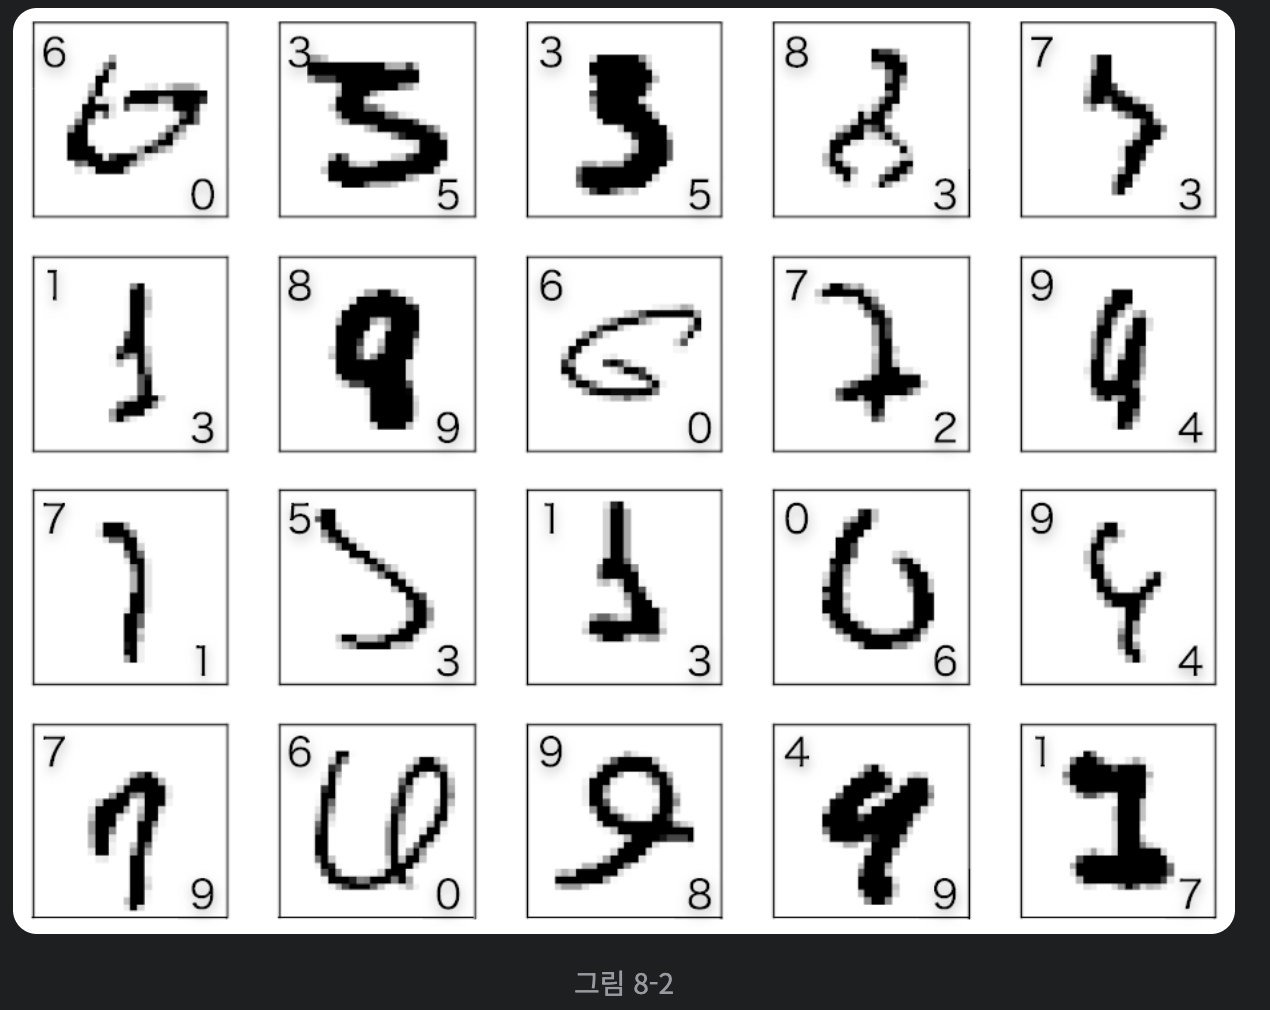

* 그림 8-2는 인식에 실패한 예시이다.

* 이번 심층 CNN은 정확도가 높고 잘못 인식한 이미지들도 인간과 비슷한 인식 오류를 저지르고 있다.

정확도를 높이기위한 방법들

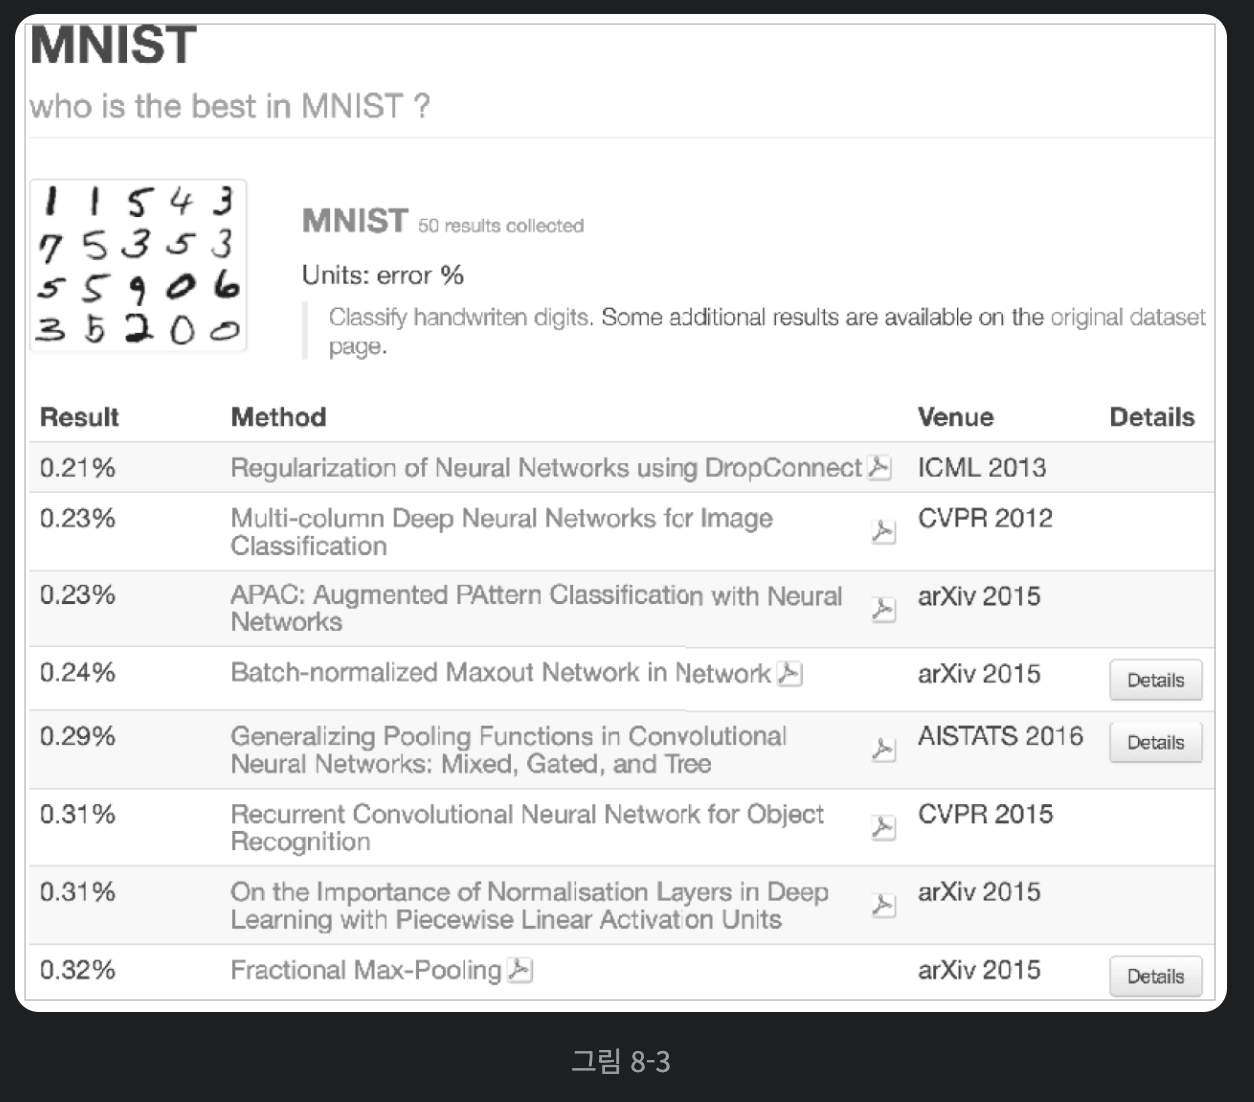

* 그림 8-3의 순위를 보면 대부분 CNN을 기초로 한 기법들이 점령했음을 알 수 있다.

* 이 목록의 기법들이 사용하는 CNN들은 그다지 깊지 않다.

* 그림 8-3의 상위 기법들을 참고하면 정확도를 더 높일 수 있는 기술이나 힌트를 발견할 수 있다. 예를 들면 앙상블 학습, 학습률 감소, 데이터 확장 등이 있다.



* 데이터 확장(data augmentation)은 입력 이미지를 알고리즘을 동원해 인위적으로 확장한다.

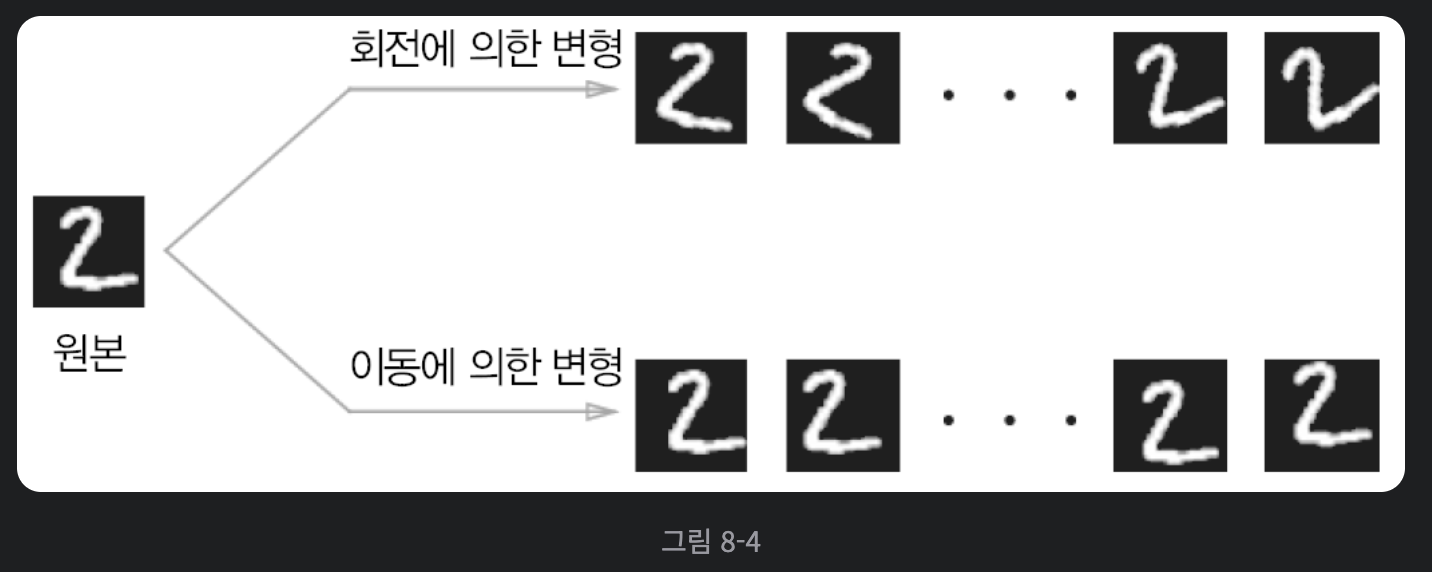

* 그림 8-4와 같이 입력 이미지를 회전하거나 세로로 이동하는 등 변화를 주어 학습 이미지의 개수를 늘리는 것이다. 이는 데이터가 몇 개 없을 때 특히 효과적인 수단이다.

* 이외에도 이미지를 잘라내는 crop이나 좌우를 뒤집는 flip 등도 있다.

깊게 하는 이유

* 층을 깊게 할 때의 이점 중 하나는 신경망의 매개변수 수가 줄어든다는 것이다.

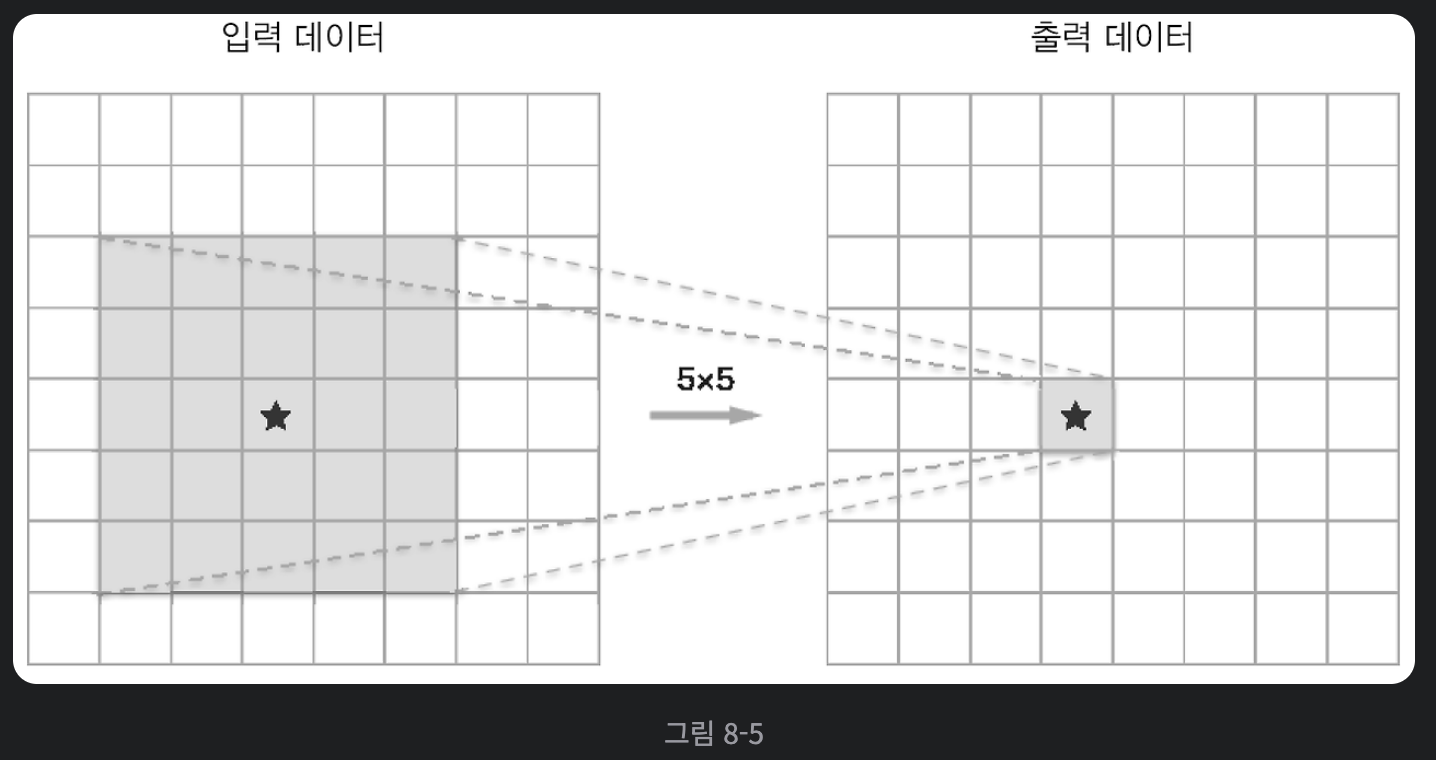

* 위 예시에서 출력 데이터의 각 노드가 입력 데이터의 어느 영역으로부터 계산되었느냐는 것이다. 그림 8-5에서는 각각의 출력 노드는 입력 데이터의 5x5 크기 영역에서 계산된다.

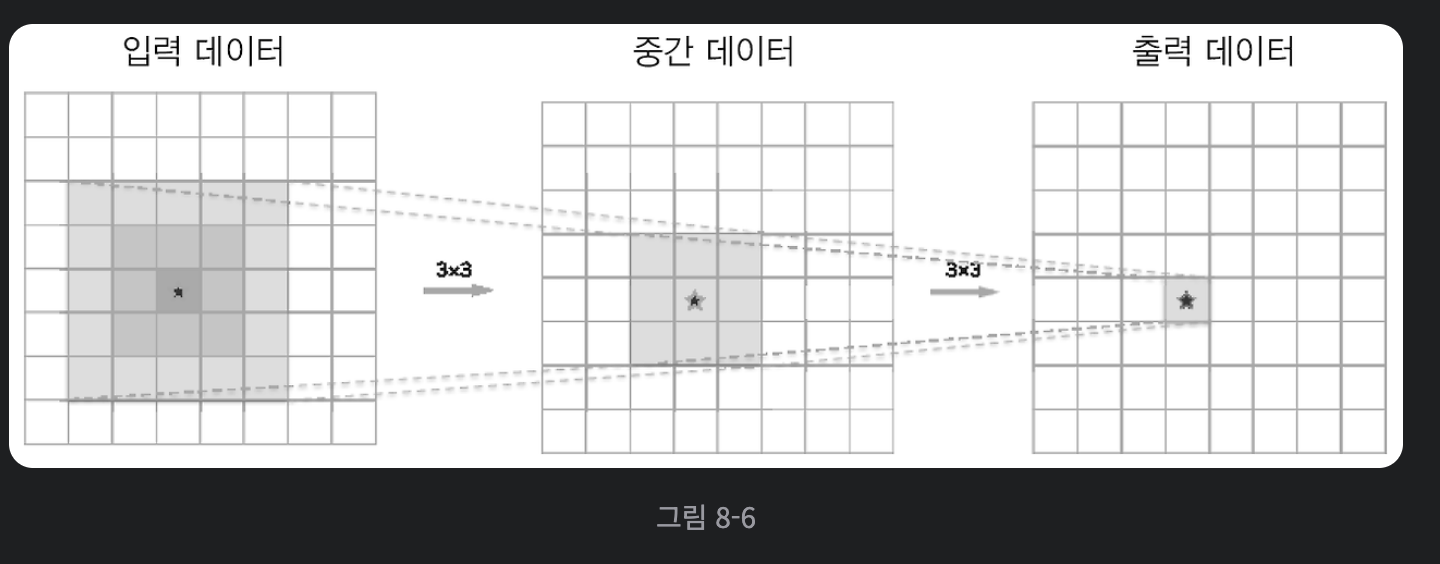

* 위 예시처럼 3x3 합성곱 연산을 2회 반복하는 경우에는 출력 노드 하나는 중간 데이터의 3x3 영역에서 계산된다. 중간 데이터의 3x3 영역은 5x5 크기의 영역에서 계산되어 나온다. 출력 데이터는 입력 데이터의 5x5 영역을 보고 계산하게 된다.

* 5x5의 합성곱 연산 1회는 3x3 합성곱 연산을 2회 수행하여 대체할 수 있다.
  * 5x5 - 25개 -> 2x3x3 - 18개
  * 3x3의 합성곱을 3번하면 모두 27개 되지만 같은 크기의 영역을 1회의 합성곱 연산으로 보기위해서는 7x7이 필요하다.

* 따라서 층이 반복할 수록 매개변수 수는 적어진다. 이 개수의 차이는 층이 깊어질수록 커진다.

* 이는 층을 깊게 함으로써 학습 데이터의 양을 줄여 학습을 고속으로 수행할 수 있다는 뜻이다.

* 또, 층을 깊게 하면 정보를 계층적으로 전달할 수 있다는 점도 중요하다. 층을 깊이 함으로써 각 층이 학습해야 할 문제를 풀기 쉬운 단순한 문제로 분해할 수 있어 효율적으로 학습하리라 기대할 수 있다.

딥러닝 고속화

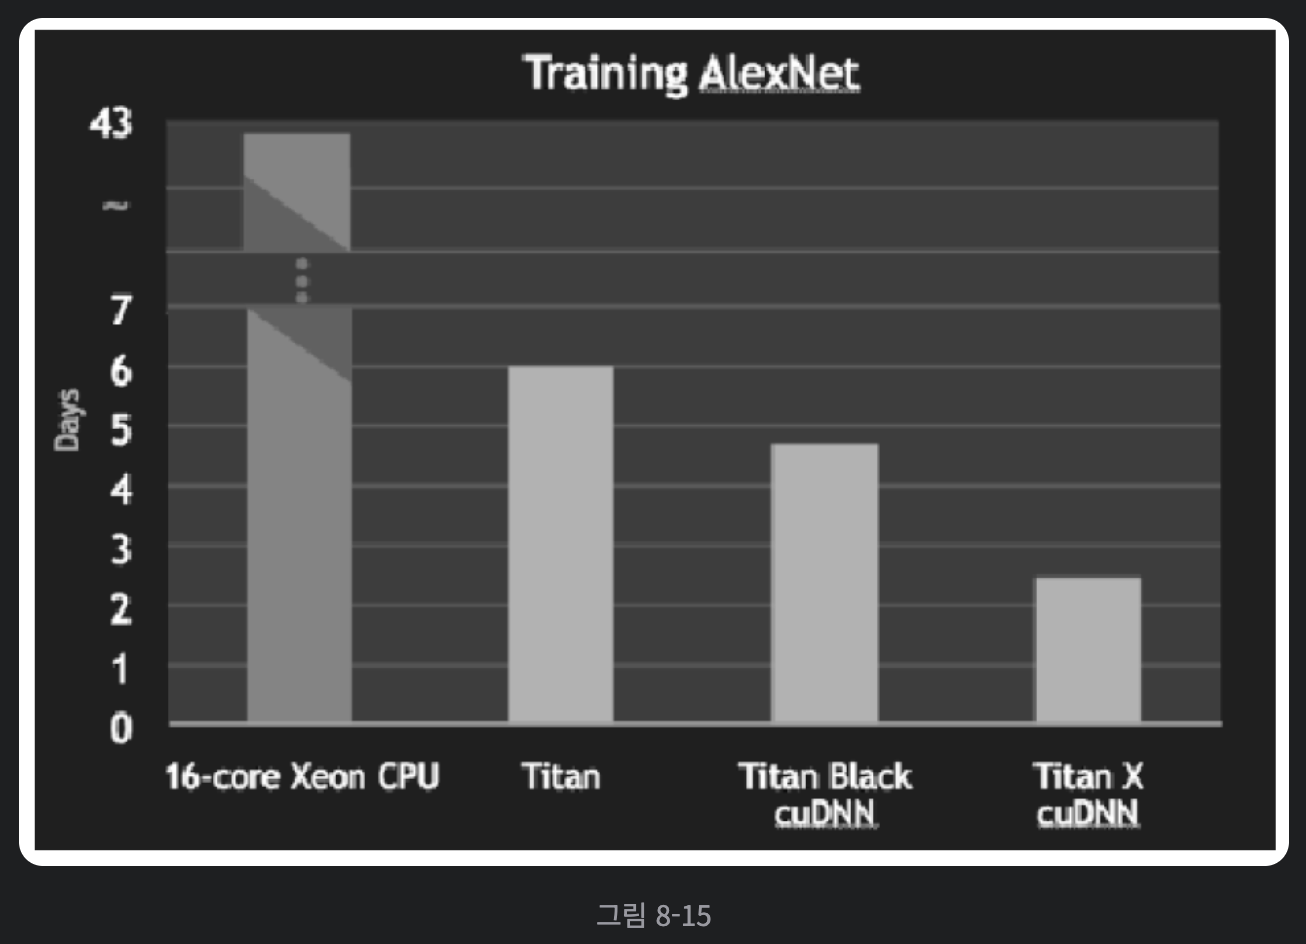

* 딥러닝에서는 대량의 단일 곱셉-누산을 수행해야 한다. 대량 병렬 연산은 GPU의 특기이다.
* GPU는 NVIDIA와 AMD 두 회사가 제공하며 딥러닝과 더 친한 쪽은 아직까지는 nvidia이다. 대부분은 nvidia의 GPU 컴퓨팅용 통합 개발 환경인 cUDA를 사용하기 때문이다.

* 그림 8-15에 있는 cuDNN은 CUDA 위에서 동작하는 라이브러리로 딥러닝에 최적화된 함수 등이 구현되어 있다.

분산 학습

* 뛰어난 신경망을 만들기 위해 시험을 수없이 반복해야 하고 그러려면 1회 학습에 걸리는 시간을 최대한 단축해야 한다. 그래서 딥러닝 학습을 수평 확장하자는 아이디어(분산 학습)가 중요해졌다.

* 딥러닝 계산을 더욱 고속화 하기 위해 다수의 GPU와 기기로 계산을 분산하기도 한다.

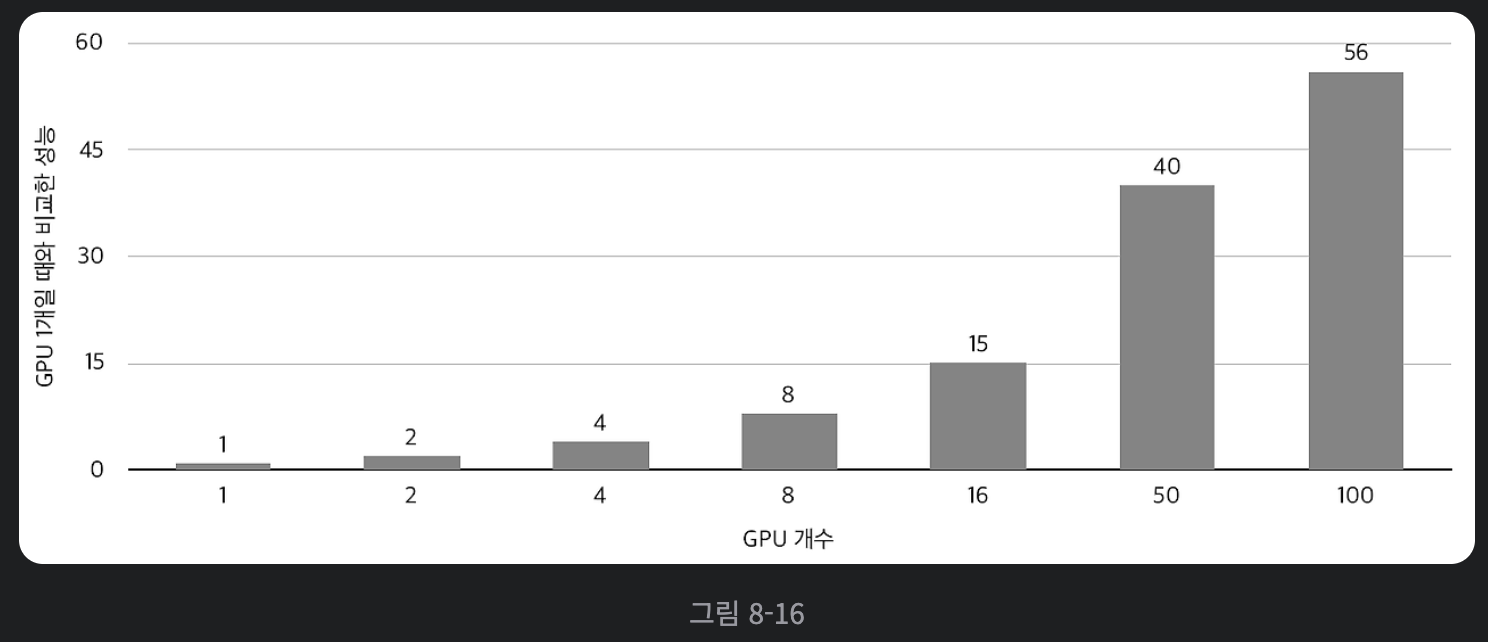

* GPU 수가 늘어남에 따라 학습도 빨라진다.

* 분산 학습에서도 계산을 어떻게 분산시키느냐는 어려운 문제이다.

연산 정밀도와 비트 줄이기

* 계산 능력 외에도 메모리 용량과 버스 대역폭 등이 딥러닝 고속화에 병목이 될 수 있다.

* 버스 대역폭 면에서는 GPU의 버스를 흐르는 데이터가 많아져 한계를 넘어서면 병목이 된다. 이러한 경우를 고려 해 네트워크로 주고받는 데이터의 비트수는 최소로 만드는 것이 바람직하다.

* 딥러닝은 높은 수치 정밀도를 요구하지 않기 때문에 16비트 반정밀도(half-precision)만 사용해도 학습에 문제가 없다고 알려져 있다.

딥러닝의 활용

detection

* CNN을 이용하여 사물 검출을 수행하는 방식 중 하나는 R-CNN이 유명하다.
이후 Faster R-cNN 기법도 등장했다.

segmentation

* segmentation이란 이미지를 픽셀 수준에서 분류하는 문제이다.
한번의 forward 처리로 모든 픽셀의 클래스를 분류해주는 FCN(Fully Convolutional Network)가 고안되었다.
  * 책에서 설명하고 있는 R-CNN과 Fast R-CNN, Faster R-CNN을 정리한 글을 작성한 적이 있어서 함께 첨부한다.

  https://iambeginnerdeveloper.tistory.com/204

사진 캡션 생성

* 딥러닝으로 사진 캡션을 생성하는 방법으로는 NIC(Neural Image Caption)모델이 대표적이다.

* NIC는 심층 CNN과 자연어를 다루는 순환 신경망(Recurrent Neural Network, RNN)으로 구성된다.

* 자연어와 같은 여러 종류의 정보를 조합하고 처리하는 것을 멀티 모달 처리라고 한다.





딥러닝의 미래

- 이미지 스타일 변환
- 이미지 생성
  * DCGAN 기술의 핵심은 생성자와 식별자로 불리는 2개의 신경망을 이용하는 것이다. 생성자가 진짜와 똑같은 이미지를 생성하고 식별자는 그것이 진짜인지를 판정한다. 그렇게 둘을 겨루도록 학습시켜 생성자는 더 정교한 가짜 이미지 생성 기술을 학습하고 식별자는 더 정확하게 간파할 수 있는 감정사로 성장한다. 이것이 GAN(Generative Adversarial Network)이며 생성자는 최종적으로는 진짜와 착각할 정도의 이미지를 그려내는 능력을 기르게 된다.

- 자율주행
- 강화학습

정리

- 수 많은 문제에서 샌경망을 더 깊게 하여 성능을 개선할 수 있다.

- 유명한 신경망으로는 VGG, GoogLeNet, ResNet이 있다.

- GPU와 분산 학습, 비트 정밀도 감소 등으로 딥러닝을 고속화 할 수 있다.

- 딥러닝은 다양한 분야에서 이용할 수 있다.